In [1]:
%pylab inline 
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import DifferentiableHOS as DHOS
import tensorflow as tf
import pickle
import jax_cosmo as jc
from flowpm.NLA_IA import k_IA
import flowpm
from jax.config import config
config.update("jax_enable_x64", True)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


2023-01-23 17:03:57.663169: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-23 17:03:57.815164: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-23 17:03:57.851769: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-23 17:03:58.439114: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
field_size=5
field_npix=1024
#####################################################################
lens_source_a=0.5226172
#####################################################################
cosmology = flowpm.cosmology.Planck15(Omega_c=0.2589,
                                          sigma8=0.8159,
                                          Omega_b=0.04860,
                                          n_s=0.9667,
                                          h=0.6774,
                                          w0=-1.0)

#####################################################################
Aia_plus=+0.001
Aia_minus=-0.001

2023-01-23 17:04:00.249202: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-23 17:04:00.981548: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5902 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 SUPER, pci bus id: 0000:a6:00.0, compute capability: 7.5


In [3]:
noise=pickle.load(open('/local/home/dl264294/peak_tune/test_jac_pk_initcond.pkl','rb'))['noise']
auto_diff=pickle.load(open('/local/home/dl264294/peak_tune/test_jac_pk_initcond.pkl','rb'))['jac']
bins=pickle.load(open('/local/home/dl264294/peak_tune/test_jac_pk_initcond.pkl','rb'))['bin']
###################################################################################################################
res=pickle.load(open('/local/home/dl264294/peak_tune/output_fid.pkl','rb'))

In [4]:
def desc_y1_analysis(kmap, noise):
    """
  Adds noise and apply smoothing we might expect in DESC Y1 SRD setting
  """
    ngal = 20
    pix_scale = field_size / field_npix * 60
    ngal_per_pix = ngal * pix_scale**2
    sigma_e = 0.26 / np.sqrt(ngal_per_pix)
    kmap = kmap + sigma_e * noise
    return kmap


def rebin(a, shape):
    sh = shape, a.shape[0] // shape
    return tf.math.reduce_mean(tf.reshape(a, sh), axis=-1)


In [5]:
kmap=res['kmap']
im_IA=res['im_IA']

In [6]:
kia_plus =desc_y1_analysis(kmap- k_IA(cosmology, lens_source_a, im_IA, Aia_plus),noise)
kia_minus=desc_y1_analysis(kmap- k_IA(cosmology, lens_source_a, im_IA, Aia_minus),noise)

In [7]:
counts_plus, bins = DHOS.statistics.peaks_histogram_tf_mulscale(
   kia_plus, nscales=7, bins=tf.linspace(-.1, 1., 8))
counts_plus = counts_plus[4:7]
counts_plus = tf.stack(counts_plus)

2023-01-23 17:04:05.594343: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2023-01-23 17:04:06.115211: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [8]:
counts_minus, bins = DHOS.statistics.peaks_histogram_tf_mulscale(
   kia_minus, nscales=7, bins=tf.linspace(-.1, 1., 8))
counts_minus = counts_minus[4:7]
counts_minus = tf.stack(counts_minus)

In [9]:
jac_num=(counts_plus-counts_minus)/(Aia_plus-Aia_minus)

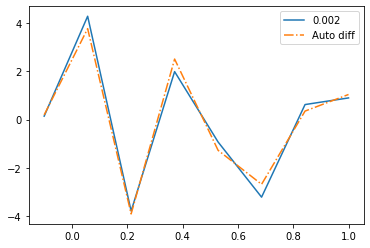

In [10]:
plot(bins, jac_num[0], label='0.002')
plot(bins,auto_diff[0,:,-1], '-.', label='Auto diff')
legend()


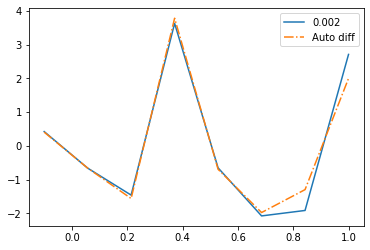

In [11]:
plot(bins, jac_num[1], label='0.002')
plot(bins,auto_diff[1,:,-1], '-.', label='Auto diff')
legend()


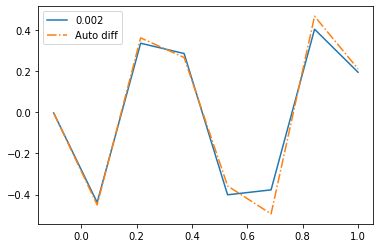

In [12]:
plot(bins, jac_num[2], label='0.002')
plot(bins,auto_diff[2,:,-1], '-.', label='Auto diff')
legend()
